# Cat-Dog-Redux Kaggle Competition
## Transfer Learning using VGG16 ImageNet

In [2]:
import os, sys
import shutil

In [3]:
def create_sample_train_dir(path):
    new_path = path+'train/'
    # Set number of files already in the train directory
    dogs = len([name for name in os.listdir(path+'sample/train/dogs/') if os.path.isfile(os.path.join(path+'sample/train/dogs/', name))])
    cats = len([name for name in os.listdir(path+'sample/train/cats/') if os.path.isfile(os.path.join(path+'sample/train/cats/', name))])
    for f in os.listdir(new_path):
        if f.split('.')[0] == 'dog' and dogs < 10:
            shutil.copy(new_path+f, path+'sample/train/dogs/')
            dogs += 1
        elif f.split('.')[0] == 'cat' and cats < 10:
            shutil.copy(new_path+f, path+'sample/train/cats/')
            cats += 1
    return os.listdir(path+'sample/train/dogs/'), os.listdir(path+'sample/train/cats/')

In [4]:
dogs, cats = create_sample_train_dir('./data/dogcats-kaggle/')
print dogs
print cats

['dog.88.jpg', 'dog.2373.jpg', 'dog.8854.jpg', 'dog.8092.jpg', 'dog.867.jpg', 'dog.6190.jpg', 'dog.2942.jpg', 'dog.12154.jpg', 'dog.1184.jpg', 'dog.3674.jpg']
['cat.3285.jpg', 'cat.12344.jpg', 'cat.4863.jpg', 'cat.11501.jpg', 'cat.4598.jpg', 'cat.2601.jpg', 'cat.8430.jpg', 'cat.4673.jpg', 'cat.6114.jpg', 'cat.10983.jpg']


In [5]:
def create_sample_val_dir(path):
    new_path = path+'train/'
    # Set number of files already in the valid directory
    dogs = len([name for name in os.listdir(path+'sample/valid/dogs/') if os.path.isfile(os.path.join(path+'sample/valid/dogs/', name))])
    cats = len([name for name in os.listdir(path+'sample/valid/cats/') if os.path.isfile(os.path.join(path+'sample/valid/cats/', name))])
    for f in os.listdir(new_path)[::-1]:
        if f.split('.')[0] == 'dog' and dogs < 5:
            shutil.copy(new_path+f, path+'sample/valid/dogs/')
            dogs += 1
        elif f.split('.')[0] == 'cat' and cats < 5:
            shutil.copy(new_path+f, path+'sample/valid/cats/')
            cats += 1
    return os.listdir(path+'sample/valid/dogs/'), os.listdir(path+'sample/valid/cats/')

In [6]:
dogs, cats = create_sample_val_dir('./data/dogcats-kaggle/')
print dogs
print cats

['dog.4274.jpg', 'dog.10477.jpg', 'dog.10156.jpg', 'dog.2105.jpg', 'dog.9786.jpg']
['cat.8188.jpg', 'cat.4436.jpg', 'cat.5256.jpg', 'cat.5165.jpg', 'cat.3081.jpg']


Organize `train` and `valid` sets

In [7]:
os.path.dirname('./data/dogcats-kaggle/train/')

'./data/dogcats-kaggle/train'

In [8]:
os.path.exists('./data/dogcats-kaggle/train/')

True

In [9]:
os.getcwd()

'/home/ubuntu/courses/deeplearning1/nbs'

In [10]:
def make_dirs():
    # make dogs and cats subdirs if they don't already exist (relative path didn't work here, so added os.getcwd())
    dog_dir = os.path.dirname(os.getcwd()+'/data/dogcats-kaggle/train/dogs/')
    cat_dir = os.path.dirname(os.getcwd()+'/data/dogcats-kaggle/train/cats/')
    val_dog_dir = os.path.dirname(os.getcwd()+'/data/dogcats-kaggle/valid/dogs/')
    val_cat_dir = os.path.dirname(os.getcwd()+'/data/dogcats-kaggle/valid/cats/')
    if not os.path.exists(dog_dir):
        os.makedirs(dog_dir)
    if not os.path.exists(cat_dir):
        os.makedirs(cat_dir)
    if not os.path.exists(val_dog_dir):
        os.makedirs(val_dog_dir)
    if not os.path.exists(val_cat_dir):
        os.makedirs(val_cat_dir)

In [11]:
make_dirs()

In [13]:
def find_break_idxs(path, train_size):
    # Count num dog and cat jpgs in train and find list breakpoint for valid
    dogs, cats = [], []
    for f in os.listdir(path+'train/'):
        if f.split('.')[0] == 'dog':
            dogs.append(f)
        elif f.split('.')[0] == 'cat':
            cats.append(f)
    # Find end index of jpg lists for training set size
    dend_idx = int(len(dogs) * train_size)
    cend_idx = int(len(cats) * train_size)
    return dend_idx, dogs, cend_idx, cats
    

In [14]:
find_break_idxs('./data/dogcats-kaggle/', .80)

(0, [], 0, [])

In [15]:
def organize_train_val(path, train_size):
    make_dirs()
    dend_idx, dogs, cend_idx, cats = find_break_idxs(path, train_size)
    # move validation dog and cat jpgs to appropriate valid directories from train
    for idx, f in enumerate(dogs):
        if idx < dend_idx: 
            shutil.move(path+'train/'+f, path+'train/dogs/'+f)
        else:
            shutil.move(path+'train/'+f, path+'valid/dogs/'+f)
    for idx, f in enumerate(cats):
        if idx < cend_idx:
            shutil.move(path+'train/'+f, path+'train/cats/'+f)
        else:
            shutil.move(path+'train/'+f, path+'valid/cats/'+f)
    return None 
#     len_train_d = len(os.listdir('./data/dogcats-kaggle/train/dogs/'))
#     len_train_c = len(os.listdir('./data/dogcats-kaggle/train/cats/'))
#     len_val_d = len(os.listdir('./data/dogcats-kaggle/valid/dogs/'))
#     len_val_c = len(os.listdir('./data/dogcats-kaggle/valid/cats/'))
#     return len_train_d, len_train_c, len_val_d, len_val_c

In [16]:
organize_train_val('./data/dogcats-kaggle/', 0.80)

## Use our Vgg16 class to finetune a Dogs vs Cats model

To change our model so that it outputs "cat" vs "dog", instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetuning looks from the outside to be identical to normal machine learning training - we provide a training set with data and labels to learn from, and a validation set to test against. The model learns a set of parameters based on the data provided.

However, the difference is that we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after calling *finetune()*.

We create our batches just like before, and making the validation set available as well. A 'batch' (or *mini-batch* as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

A few basic libraries that we'll need for the initial exercises:

In [26]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from vgg16 import Vgg16

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [27]:
import utils; reload(utils)
from utils import plots

### Finetune vgg16 to cat-dog-redux and make predictions on test set


In [37]:
path = './data/dogcats-kaggle/'

batch_size=64

In [38]:
path

'./data/dogcats-kaggle/'

Calling *finetune()* modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

Finally, we *fit()* the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An *epoch* is one full pass through the training data.)

In [30]:
vgg = Vgg16()
batch_size = 64

batches = vgg.get_batches(path+'train/', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid/', batch_size=batch_size)

vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=2)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/2
20000/20000 [==============================] - 634s - loss: 0.1267 - acc: 0.9665 - val_loss: 0.0763 - val_acc: 0.9798
Epoch 2/2
20000/20000 [==============================] - 633s - loss: 0.0910 - acc: 0.9790 - val_loss: 0.0687 - val_acc: 0.9838


Make predictions on the test set once the model has been fit

In [39]:
test_batches, predictions = vgg.test(path+'test/', batch_size=64)

Found 12500 images belonging to 1 classes.


In [32]:
test_batches.filenames

['unknown/9292.jpg',
 'unknown/12026.jpg',
 'unknown/9688.jpg',
 'unknown/4392.jpg',
 'unknown/779.jpg',
 'unknown/2768.jpg',
 'unknown/2399.jpg',
 'unknown/12225.jpg',
 'unknown/10947.jpg',
 'unknown/1780.jpg',
 'unknown/11631.jpg',
 'unknown/8478.jpg',
 'unknown/7940.jpg',
 'unknown/5102.jpg',
 'unknown/1704.jpg',
 'unknown/5967.jpg',
 'unknown/1261.jpg',
 'unknown/11882.jpg',
 'unknown/3237.jpg',
 'unknown/10222.jpg',
 'unknown/10854.jpg',
 'unknown/6810.jpg',
 'unknown/8615.jpg',
 'unknown/6014.jpg',
 'unknown/7161.jpg',
 'unknown/7934.jpg',
 'unknown/6549.jpg',
 'unknown/2715.jpg',
 'unknown/6139.jpg',
 'unknown/6873.jpg',
 'unknown/4470.jpg',
 'unknown/9417.jpg',
 'unknown/8911.jpg',
 'unknown/878.jpg',
 'unknown/10159.jpg',
 'unknown/8553.jpg',
 'unknown/7897.jpg',
 'unknown/2271.jpg',
 'unknown/6094.jpg',
 'unknown/10906.jpg',
 'unknown/6945.jpg',
 'unknown/9578.jpg',
 'unknown/1839.jpg',
 'unknown/11121.jpg',
 'unknown/6599.jpg',
 'unknown/2047.jpg',
 'unknown/6138.jpg',
 'unk

Found 12500 images belonging to 1 classes.


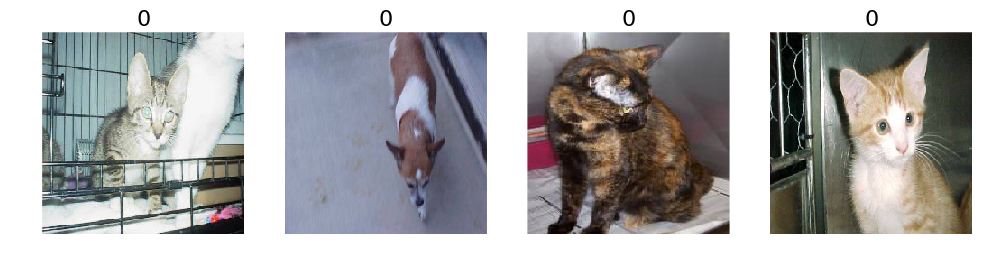

In [40]:
# Turn off shuffle so predicitons and test images keep same order (need to change this so it's more robust eventually)
test_batch = vgg.get_batches(path+'test/', batch_size=4, shuffle=False)
img, labels = next(test_batch)
#0 = cat, 1 = dog
plots(img, titles=predictions.argmax(axis=1))

Found 12500 images belonging to 1 classes.


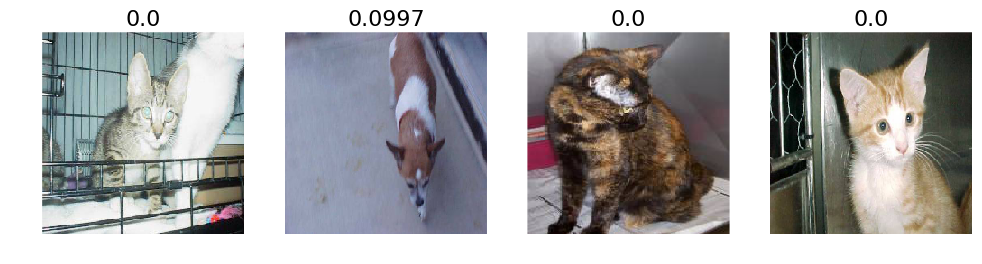

In [41]:
# Turn off shuffle so predicitons and test images keep same order (need to change this so it's more robust eventually)
test_batch = vgg.get_batches(path+'test/', batch_size=4, shuffle=False)
img, labels = next(test_batch)
#Probability image is a DOG
plots(img, titles=np.around(predictions[:,1], decimals=4))

In [119]:
#format of labels
labels

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

In [47]:
#format of predictions returned by vgg.test()
print(type(predictions))
#These are probabilities of being from cat or dog class
print(predictions[:2])
print("index 0 --> classified cat \nindex 1 --> classified dog")
predictions[:2].argmax(axis=1)

<type 'numpy.ndarray'>
[[  1.0000e+00   1.7784e-12]
 [  3.0493e-01   6.9507e-01]]
index 0 --> classified cat 
index 1 --> classified dog


array([0, 1])

### Try dog dressed as a cat photo

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


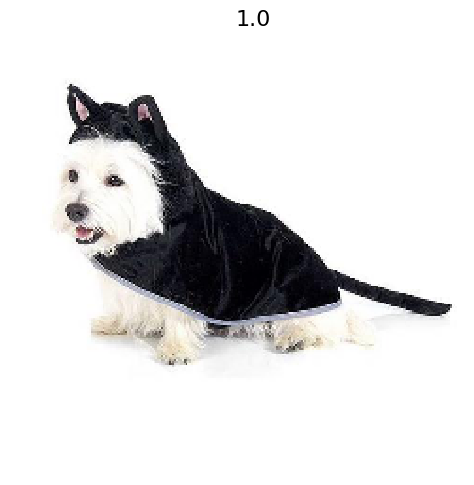

In [35]:
path = './data/dogcats-kaggle/test-custom'
test_batches, predictions = vgg.test(path, batch_size=1)

# Turn off shuffle so predicitons and test images keep same order (need to change this so it's more robust eventually)
test_batch = vgg.get_batches(path, batch_size=4, shuffle=False)
img, labels = next(test_batch)
#Probability image is a DOG
plots(img, titles=np.around(predictions[:,1], decimals=4))

# Export predictions with img id and classification

Need to retool the vgg.test() method to spit out the image id with the associated probability the image is of a **dog**

In [90]:
import re
import csv

In [91]:
path

'./data/dogcats-kaggle/'

In [76]:
string = 'unknown/38582.jpg'
re.findall(r'\d+', string)

['38582']

In [97]:
def create_predictions_csv(test_batches, predictions):
    # Get a list of the image's file id in the order they were processed
    file_ids = [int(re.findall(r'\d+', jpg)[0]) for jpg in test_batches.filenames]
    # Probability each image is a DOG 
    #predictions = list(predictions[:,1])
    predictions = list(np.around(predictions[:,1], decimals=4))
    # Write CSV file of predictions
    new_csv = path+'predictions.csv'
    with open(new_csv, 'wb+') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['id','label'])
        for img_pred in zip(file_ids, predictions):
            writer.writerow(img_pred)
        

In [98]:
create_predictions_csv(test_batches, predictions)

In [100]:
!head './data/dogcats-kaggle/predictions.csv'

Yay